In [59]:
import pandas as pd
import matplotlib.pyplot as plt

### Resumo

**Analistas de Dados**
<br> Seu trabalho vai ser entender o perfil de fraude

*júnior*
- Quais métricas (KPIs) são importantes para o problema de fraude? Veja as “notas importantes” para isso e pesquisem!
- Como estão esses nossos KPIs atualmente?
- Quanto estamos perdendo atualmente em fraude x quanto estamos ganhando em aprovação? Note que temos apenas uma amostra de dados, então não temos aqui os valores totais de perdas. Escreva esse disclaimer
- Ententa como está o perfil geral de features - análise univariada. Procure aqui também por anomalias, nulos, etc
- Agora entenda o perfil do fraudador. Veja cada feature em relação aos fraudadores x não fraudadores. Use e abuse de correlações, testes de hipótese, etc
- <s>Faça um PowerBI ou Looker com os principais KPIs e gráficos que geram insights nesse tema</s>

*pleno*
- Use alguns algoritmos para melhor entendimento do perfil de fraude, como regressão logística ou algum outro que achar válido

*sênior*
- Construa “regras duras” para evitarmos fraude sem o uso de machine learning. Aqui são regras mesmo, por exemplo, se valor acima de X então barramos uma transação
- Discuta os prós e contras dessa sua estratégia
- Simule perdas e ganhos da estratégia
- Desenhe um teste AB para testarmos sua estratégia

**Cientistas de Dados**

*júnior*
- Façam uma EDA - Análise exploratória de dados. Podem se basear nas perguntas do analista para isso
- Desenvolva um modelo para predizer a variável Fraude (1-Sim, 0-Não). Quais técnicas testou? Qual selecionou como melhor abordagem? Explique!
- Compare o desempenho do seu algoritmo com o desempenho de um modelo anterior, cujo resultado é encontrado na coluna Score_fraude_modelo do dataset. Quais métricas usou e qual sua conclusão?
- Queremos encontrar o ponto de threshold ideal para o modelo já treinado apresentado na parte (Score, onde 0 (zero) é o risco mais baixo e 100 (cem) o mais alto). Defina o ponto de corte que maximize os lucros da empresa, de forma que todos os pagamentos com menor Score sejam aprovados e os maiores sejam rejeitados.

*pleno*
- Como você pode garantir que o desempenho do modelo no laboratório vai ser um proxy para o desempenho do modelo em produção?
- Supondo que o desempenho produtivo seja muito diferente do esperado, quais você acha que são as causas mais prováveis?
- Se o modelo precisar responder online, no menor tempo possível, o que isso mudaria no desenvolvimento do seu modelo?

<s>*sênior - projeto de alto impacto - ML Engineers*</s>

<s>Para aqueles que estão buscando vagas mais sênior ou realmente um projeto que destaque MUITO você. Minha dica é fazer isso se você já tiver estudado machine learning muito bem e já possa partir para conceitos de deploy 👇</s>
- <s>Use ferramentas como o MLFlow para testes</s>
- <s>Simule um deploy do modelo. Use Docker, Kuberneters, AWS, etc. Tudo que achar necessário para fazer o deploy</s>
- <s>Pense no monitoramento do modelo</s>

***Notas importante***

- Pra fins desse case os dados são anonimizados propositadamente. Para resolvê-lo, vocês vão precisar fazer algumas suposições. Justifique toda suposição que fizer
- Sabemos que a empresa ganha 10% do valor de um pagamento aprovado corretamente e a cada fraude aprovada perdemos 100% do valor do pagamento.

***Dados***

- **score_1** a **score_10**: São notas de bureau de crédito que a empresa adquiriu para identificar se o comprador é confiável ou outros dados anonimizados que não temos informação sobre
- **País**: pais de compra
- **Produto:** produto que está sendo comprado no e-commerce
- **Categoria_produto**: categoria a qual esse produto se encaixa
- **Entrega_doc_1** a **entrega_doc_3**: Documentos requisitados no momento de fazer a conta. 0 = N = nao entregou. Y = 1 = entregou. Se vazio, considere que nao entregou
- **Score_fraude_modelo**: score dado pelo modelo atual. É a probabilidade daquela compra ser uma fraude ou nao. Quanto mais próximo de 100, maior a certeza do modelo que é fraude
- **Fraude**: informacao se aquela compra era fraudulenta ou nao. Foi inserida após alguns dias, para termos o feedback real se de fato era fraudulenta ou nao. 0 se nao era fraudulenta e 1 se era fraudulenta

### **Cleaning** and **Modeling**

In [60]:
df = pd.read_csv('../../data/09. TCC/fraude/dados - dados.csv')
cols = list(df.columns)
cols.sort()
df = df[cols].copy()

df['datahora_compra'] = pd.to_datetime(df['data_compra'])
df['data_compra'] = df['datahora_compra'].dt.date
df['entrega_doc_2'] = df['entrega_doc_2'].apply(lambda x: 1 if x == 'Y' else 0)
df['entrega_doc_3'] = df['entrega_doc_3'].apply(lambda x: 1 if x == 'Y' else 0)

## corrigindo produtos com duas ou mais categorias, sua categoria oficial é a que mais aparece
df_qtde_categorias_produto = df.groupby('produto')['categoria_produto'].nunique().reset_index(name='qtde_categ')
df_qtde_categorias_produto = df_qtde_categorias_produto[df_qtde_categorias_produto['qtde_categ'] > 1]
for produto in df_qtde_categorias_produto['produto'].unique(): 
    df_qtde_categorias_produto = df[df['produto'] == produto].copy()

    oficial_categ = df_qtde_categorias_produto['categoria_produto'].value_counts().sort_values().index[-1]
    produto_indexes = df_qtde_categorias_produto.index
    df.loc[produto_indexes, 'categoria_produto'] = oficial_categ

## nivelando categoria de produtos
# todos os niveis possuem (quase ~ por causa dos percentis) o mesmo numero de compras
# niveis maiores (A até D) precisam de menos categorias para chegar no mesmo numero de compras que niveis menores, 
#    i.e. compras de categorias com niveis altos em média acontecem com mais frequencia que niveis baixos.
# semelhante a pareto:
#    A: 1°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
#    B: 2°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
#    C: 3°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
#    D: 4°as categorias que correspondem a 25% das compras (aparecimentos = linhas)
df['categ_nivel'] = None

df_categ_freqs = df['categoria_produto'].value_counts().reset_index(name='frequencia')
df_categ_freqs['proporcao_frequencia_acumulada'] = df_categ_freqs['frequencia'].cumsum()/df_categ_freqs['frequencia'].sum()
niveis = [*'ABCD']
props = list(range(0, 101, 25))
for i in range(1, len(props)):
    lower = props[i-1]/100
    upper = props[i]/100
    nivel = niveis[i-1]
    categs = df_categ_freqs[(df_categ_freqs['proporcao_frequencia_acumulada'] > lower) & (df_categ_freqs['proporcao_frequencia_acumulada'] <= upper)]['categoria_produto']

    df.loc[df['categoria_produto'].isin(categs), 'categ_nivel'] = nivel
df = df.drop('categoria_produto', axis=1)

## nivelando produtos (só para produtos que tem mais que uma compra, caso contrario produto terá nivel E)
# todos os niveis possuem (quase ~ por causa dos percentis) o mesmo numero de compras
# niveis maiores (A até D) precisam de menos produtos para chegar no mesmo numero de compras que niveis menores, 
#    i.e. compras de produtos com niveis altos em média acontecem com mais frequencia que niveis baixos.]
# semelhante a pareto: **(só para produtos que tem mais que uma compra)**
#    A: 1°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
#    B: 2°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
#    C: 3°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
#    D: 4°as produtos que correspondem a 25% das compras (aparecimentos = linhas)
df['prod_nivel'] = None

df_prod_freqs = df['produto'].value_counts().reset_index(name='frequencia')
df_prod_freqs = df_prod_freqs[df_prod_freqs['frequencia'] > 1].copy()
df_prod_freqs['proporcao_frequencia_acumulada'] = df_prod_freqs['frequencia'].cumsum()/df_prod_freqs['frequencia'].sum()
niveis = [*'ABCD']
props = list(range(0, 101, 25))
for i in range(1, len(props)):
    lower = props[i-1]/100
    upper = props[i]/100
    nivel = niveis[i-1]
    prods = df_prod_freqs[(df_prod_freqs['proporcao_frequencia_acumulada'] > lower) & (df_prod_freqs['proporcao_frequencia_acumulada'] <= upper)]['produto']

    df.loc[df['produto'].isin(prods), 'prod_nivel'] = nivel
df['prod_nivel'] = df['prod_nivel'].fillna('E')
df = df.drop('produto', axis=1)

df = df.dropna(subset='pais') ## linhas com paises nulos correspondem a menos que 1% do dadaset

df = df.sort_values(by='data_compra')
df

,data_compra,entrega_doc_1,entrega_doc_2,entrega_doc_3,fraude,pais,score_1,score_10,score_2,score_3,...,score_5,score_6,score_7,score_8,score_9,score_fraude_modelo,valor_compra,datahora_compra,categ_nivel,prod_nivel
127373,2020-03-08,1,0,1,0,BR,4,160.0,0.7123,3149.69,...,0.231621,10.0,15,0.298562,1105.0,0,6.62,2020-03-08 19:25:40,D,E
33084,2020-03-08,1,1,1,0,BR,4,601.0,0.6414,43805.65,...,0.192246,15.0,53,0.059839,3298.0,21,13.76,2020-03-08 09:15:22,D,D
47426,2020-03-08,1,0,1,0,BR,4,184.0,0.7234,145390.15,...,0.493213,22.0,5,0.666123,1711.0,69,4.91,2020-03-08 21:59:22,D,E
123772,2020-03-08,1,0,1,0,AR,4,382.0,0.5677,95994.03,...,0.000000,73.0,11,0.876665,2594.0,95,65.91,2020-03-08 20:56:18,D,E
39367,2020-03-08,1,0,1,0,AR,2,906.0,0.7436,213735.74,...,0.000000,2.0,5,0.556053,2110.0,23,417.91,2020-03-08 09:42:19,D,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113303,2020-04-21,1,0,1,0,BR,4,143.0,0.7678,57946.53,...,0.196732,24.0,20,0.719288,2423.0,42,5.79,2020-04-21 14:23:24,B,E
49637,2020-04-21,0,0,0,0,AR,2,83.0,0.7790,21811.85,...,0.000000,8.0,22,0.550055,83.0,7,47.55,2020-04-21 15:10:56,D,E
66265,2020-04-21,1,0,1,0,BR,4,1412.0,0.7551,80270.67,...,0.000000,16.0,24,0.245005,2081.0,11,27.38,2020-04-21 11:28:45,B,E
26617,2020-04-21,1,0,1,0,BR,4,664.0,0.7413,10226.68,...,0.000000,20.0,3,0.895411,931.0,26,23.16,2020-04-21 16:06:06,B,C


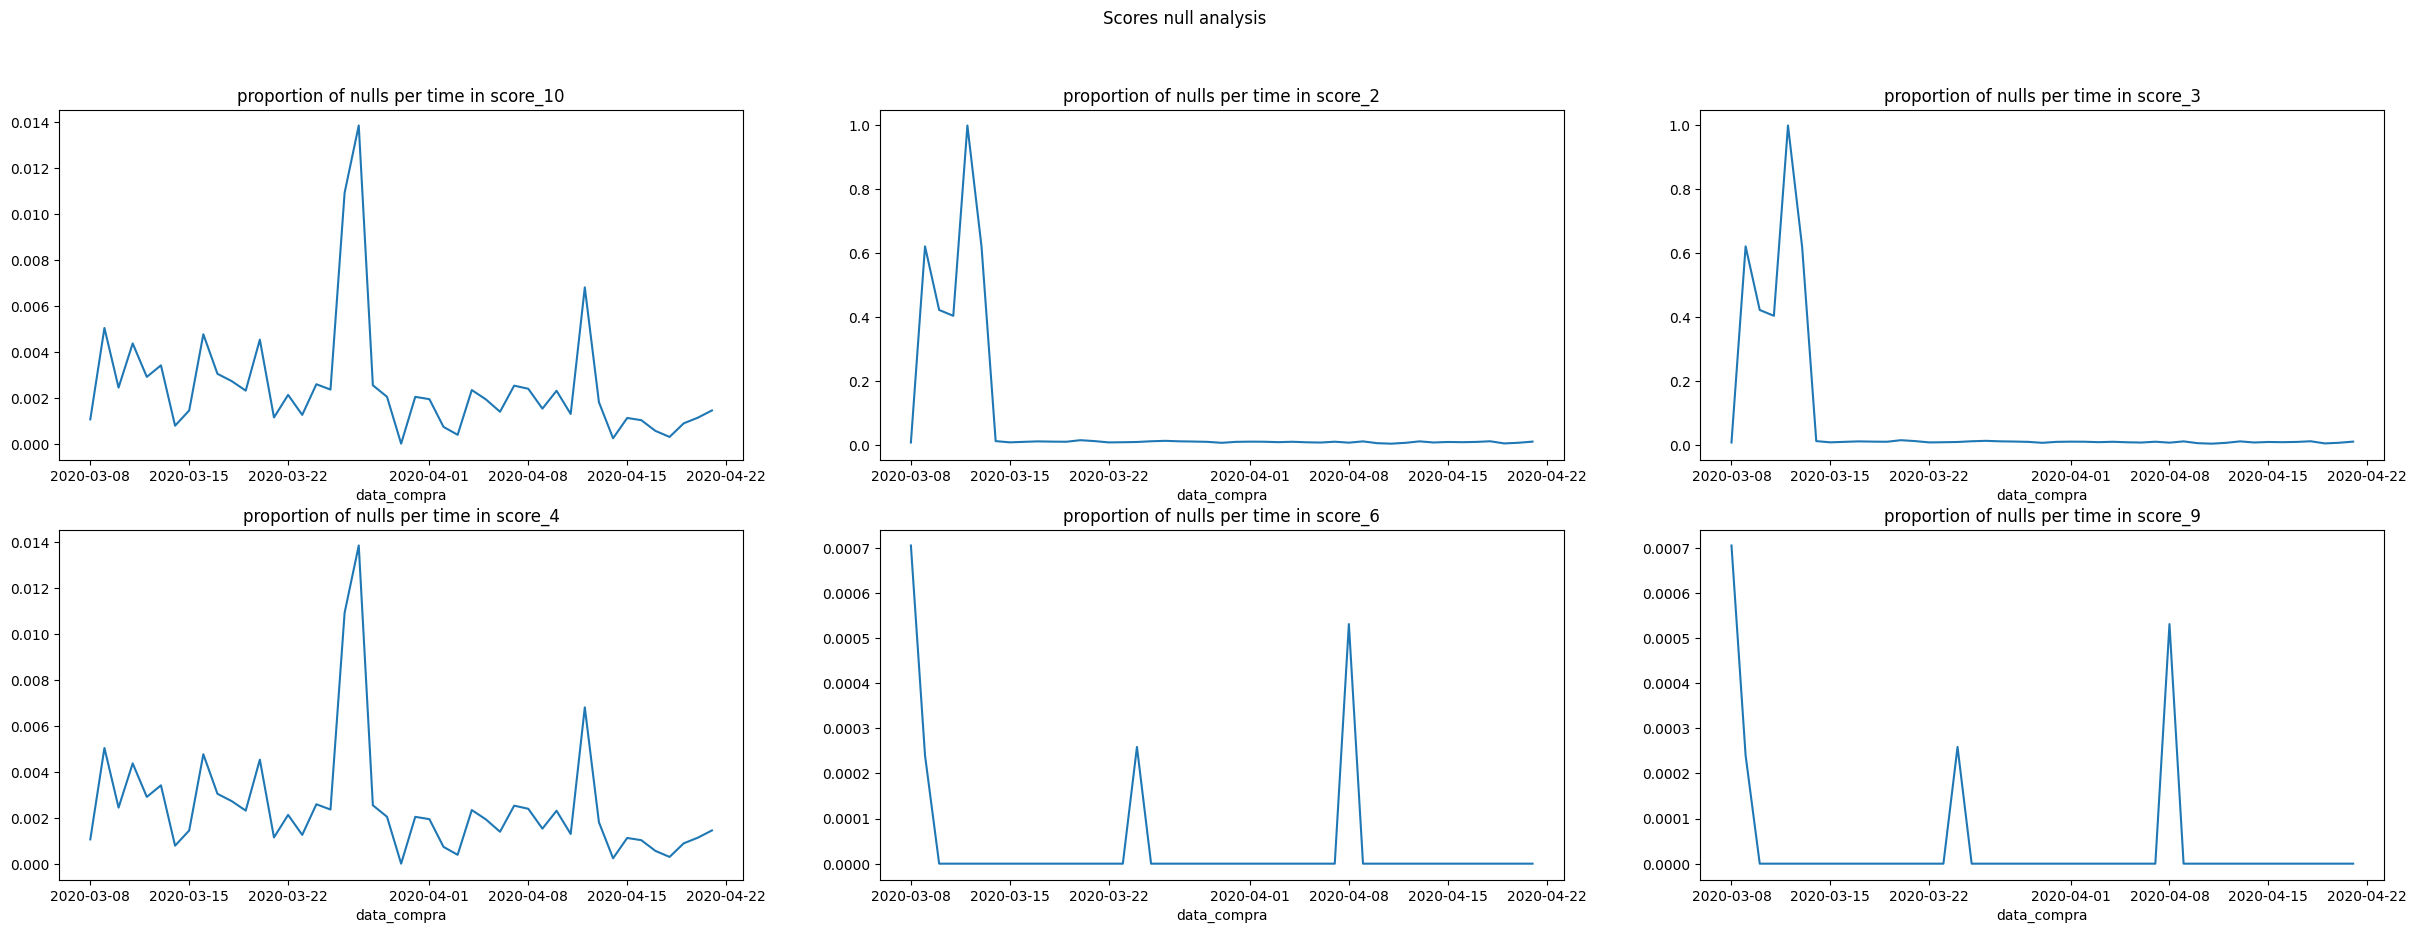

score nulls:


score_10      364
score_2     12973
score_3     12973
score_4       364
score_6         6
score_9         6
dtype: int64

score_10    364
score_4     364
dtype: int64

score_2    12973
score_3    12973
dtype: int64

score_6    6
score_9    6
dtype: int64

In [61]:

fig, ax = plt.subplots(2, 3, figsize=(30, 10))

score_with_null_cols = [col for col in df.columns if 'score' in col and 'modelo' not in col and df[col].isna().sum() > 0]
for i, col in enumerate(score_with_null_cols):
    x_pos = i//3
    y_pos = i%3

    df[['data_compra',col]].groupby('data_compra')[col].apply(lambda x: len([x_i for x_i in x if str(x_i) == 'nan'])/len(x) ).plot.line(ax=ax[x_pos, y_pos])
    ax[x_pos, y_pos].set_title(f'proportion of nulls per time in {col}')

plt.suptitle(f'Scores null analysis')
plt.show()

print('score nulls:')
display(df[score_with_null_cols].isna().sum())
display(df[df['score_10'].isna()][['score_10','score_4']].isna().sum())
display(df[df['score_2'].isna()][['score_2','score_3']].isna().sum())
display(df[df['score_6'].isna()][['score_6','score_9']].isna().sum())

### **EDA**

In [62]:

print(df.shape)
print(f"data date range: {df['datahora_compra'].min()} to {df['datahora_compra'].max()} ~ {(df['datahora_compra'].max()-df['datahora_compra'].min())} of data")
print('target col: <fraude>')
print('leak for target col: <score_fraude_modelo>')
display(
    pd.DataFrame({
        'Tipo': df.dtypes,
        'Qtde nulos': df.isnull().sum(),
        'Proporção nulos': df.isnull().mean(),
        'Qtde unicos': df.nunique(),
        'Exemplo unicos': df.apply(lambda x: x.unique()[:3])
    })
)

(149806, 21)
data date range: 2020-03-08 00:02:15 to 2020-04-21 23:59:56 ~ 44 days 23:57:41 of data
target col: <fraude>
leak for target col: <score_fraude_modelo>


,Tipo,Qtde nulos,Proporção nulos,Qtde unicos,Exemplo unicos
data_compra,object,0,0.000000,45,"[2020-03-08, 2020-03-09, 2020-03-10]"
entrega_doc_1,int64,0,0.000000,2,"[1, 0]"
entrega_doc_2,int64,0,0.000000,2,"[0, 1]"
entrega_doc_3,int64,0,0.000000,2,"[1, 0]"
fraude,int64,0,0.000000,2,"[0, 1]"
pais,object,0,0.000000,51,"[BR, AR, US]"
score_1,int64,0,0.000000,4,"[4, 2, 3]"
score_10,float64,364,0.002430,1792,"[160.0, 601.0, 184.0]"
score_2,float64,12973,0.086599,7668,"[0.7123, 0.6414, 0.7234]"
score_3,float64,12973,0.086599,134909,"[3149.69, 43805.65, 145390.15]"
